In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.sparse as sp
from heapq import nlargest

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /opt/conda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /opt/conda/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
pd.set_option('display.max_colwidth', 0)

In [4]:
colour_dict = {
    "Liberal": "red",
    "Conservative": "blue",
    "New Democratic Party": "orange",
    "Green Party": "green",
    "Bloc Québécois": "teal",
    "Independent": "grey",
    "People's Party": "purple"
}

# Data Importation

In [5]:
#import zipfile
#with zipfile.ZipFile(os.getcwd() + "/42nd Parliament/42nd Parliament.zip", 'r') as zip_ref:
#    zip_ref.extractall(os.getcwd() + "/42nd Parliament")

In [6]:
df_lst = []
file_path = os.getcwd() + "/42nd Parliament/42nd Parliament/"

file_list = pd.to_datetime(pd.Series(os.listdir(file_path)).str[:-4]).dt.date.sort_values().reset_index(drop=True)

for f in file_list:
    df_lst += [pd.read_csv(file_path + f.strftime("%-Y-%-m-%-d") + '.csv')]

In [7]:
mp_df = pd.read_csv(os.getcwd() + "/42nd Parliament/mps-42.csv").replace("NDP", "New Democratic Party")
mp_df["Full Name"] = mp_df["First Name"] + " " + mp_df["Last Name"]

# Initial Processing

In [8]:
full_df = pd.concat(df_lst)
full_df["speakerparty"] = full_df["speakerparty"].replace("NDP", "New Democratic Party")
full_df["speakerparty"] = full_df["speakerparty"].replace("Bloc", "Bloc Québécois")
full_df["speakerparty"] = full_df["speakerparty"].replace("Green", "Green Party")

In [9]:
number_of_mps = len(mp_df)

# Overall Measures

In [10]:
total_num_speeches = len(full_df["speechtext"])
unique_mp_speakers = set(mp_df["Full Name"]).intersection(set(full_df["speakername"].unique()))

num_mps_by_party = mp_df["Political Affiliation"].value_counts()
list_of_parties = list(num_mps_by_party.index)
total_num_speeches_by_party = full_df["speakerparty"].value_counts()
total_speeches_by_day = {x["speechdate"].iloc[0]: len(x["speechtext"]) for x in df_lst}

In [11]:
len(unique_mp_speakers)

339

<b><u>Table 1: Number of MPs by Party in the 42nd Canadian Parliament</u></b>

In [14]:
pd.DataFrame(num_mps_by_party).T

,Liberal,Conservative,New Democratic Party,Bloc Québécois,Independent,Green Party,People's Party,Co-operative Commonwealth Federation
Political Affiliation,185,106,43,10,8,2,1,1


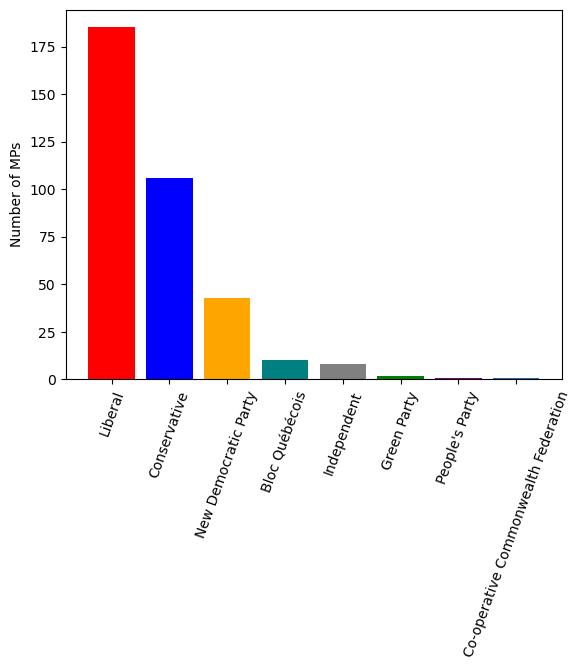

In [15]:
for party in list_of_parties:
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.bar(party, num_mps_by_party[party], color=colour)

plt.ylabel("Number of MPs")
plt.xticks(ticks=range(len(list_of_parties)), labels=list_of_parties, rotation=70)
plt.show()

<b><u>Figure 1: Number of MPs by Party in the 42nd Canadian Parliament</u></b>:
>As can be seen, the largest parties are the Liberal Party (which has a majority government), followed by the Conservative Party and New Democratic Party. These three form the largest Centrist, Right- and Left-wing parties in Canada. Of note, there were only ever 338 members sitting at any given time.

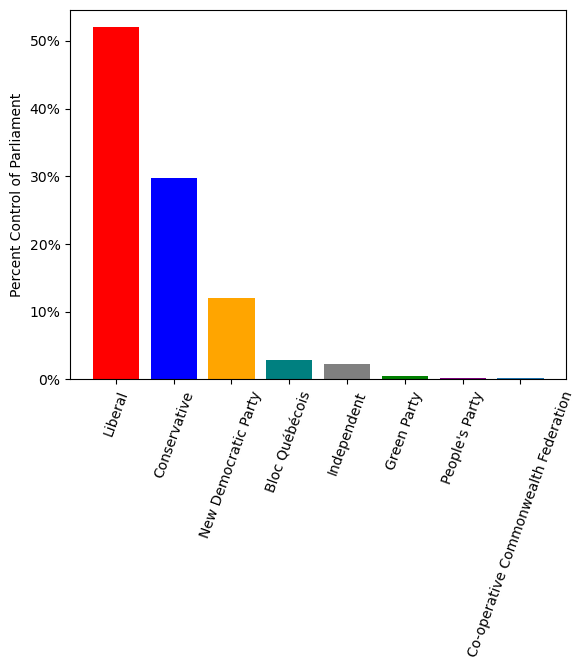

In [16]:
for party in list_of_parties:
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.bar(party, num_mps_by_party[party]/number_of_mps, color=colour)

plt.ylabel("Percent Control of Parliament")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(ticks=range(len(list_of_parties)), labels=list_of_parties, rotation=70)
plt.show()

<b><u>Figure 2: Percent Control by Party of the 42nd Canadian Parliament</u></b>:
>The Liberal Party controls slightly over 50% of parliamentary seats, giving them a full majority. The Conservative Party and New Democratic Party control roughly 30% and 10% of seats respectively.

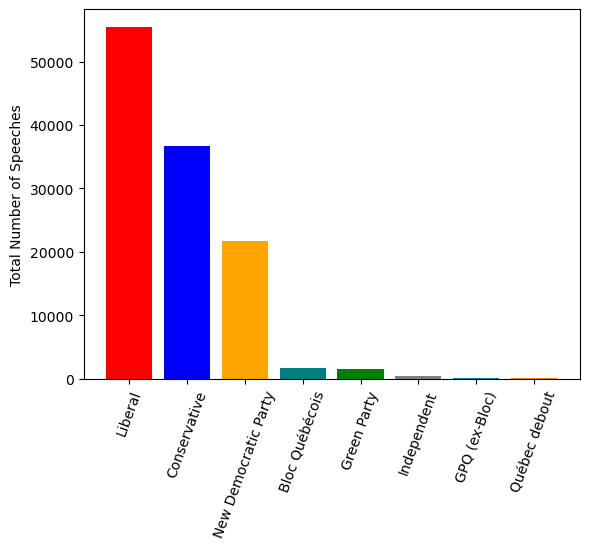

In [17]:
for party in total_num_speeches_by_party.keys():
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.bar(party, total_num_speeches_by_party[party], color=colour)

plt.ylabel("Total Number of Speeches")
plt.xticks(ticks=range(len(total_num_speeches_by_party)), labels=total_num_speeches_by_party.keys(), rotation=70)
plt.show()

<b><u>Figure 3: Total Number of Speeches by Party</u></b>:
>The Liberal Party made the most speeches, with the Conservatives and New Democratic Party each making a substantial number of speeches throughout the 42nd Parliament. In total, 129,743 speeches were delivered.

In [18]:
months_in_session = full_df["speechdate"].astype(str).str[:7].unique()

unique_party_speakers_by_month = full_df.groupby([(pd.to_datetime(full_df["speechdate"]).dt.year), (pd.to_datetime(full_df["speechdate"]).dt.month)])["speakerparty", "speakername"].value_counts()

/tmp/ipykernel_178/3848517382.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  unique_party_speakers_by_month = full_df.groupby([(pd.to_datetime(full_df["speechdate"]).dt.year), (pd.to_datetime(full_df["speechdate"]).dt.month)])["speakerparty", "speakername"].value_counts()


In [19]:
party_speeches_by_month_dict = {}
for party in total_num_speeches_by_party.keys():
    party_speeches_by_month_dict[party] = []

for month in months_in_session:
    y, m = month.split('-')
    for party in total_num_speeches_by_party.keys():
        if party in unique_party_speakers_by_month[int(y)][int(m)].index:
            party_speeches_by_month_dict[party] += [np.sum(unique_party_speakers_by_month[int(y)][int(m)][party])]
        else:
            party_speeches_by_month_dict[party] += [0]

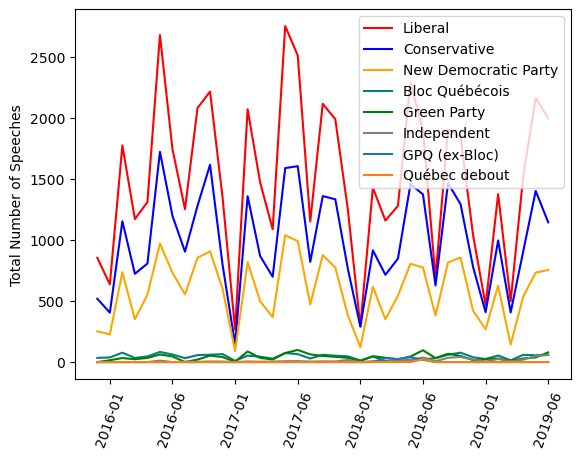

In [20]:
legend_list_of_parties = []
for party in party_speeches_by_month_dict.keys():
    colour = colour_dict[party] if party in colour_dict.keys() else None
    legend_list_of_parties += [party]
    plt.plot(party_speeches_by_month_dict[party], color=colour)

tick_locations = np.arange(1, len(months_in_session), 5)
plt.ylabel("Total Number of Speeches")
plt.xticks(ticks=tick_locations, labels=months_in_session[tick_locations], rotation=70)
plt.legend(legend_list_of_parties)
plt.show()

<b><u>Figure 4: Number of Speeches Given by Each Party Over Time</u></b>:
>In every month the Liberal party made the most overall speeches, followed closely by the Conservative party.

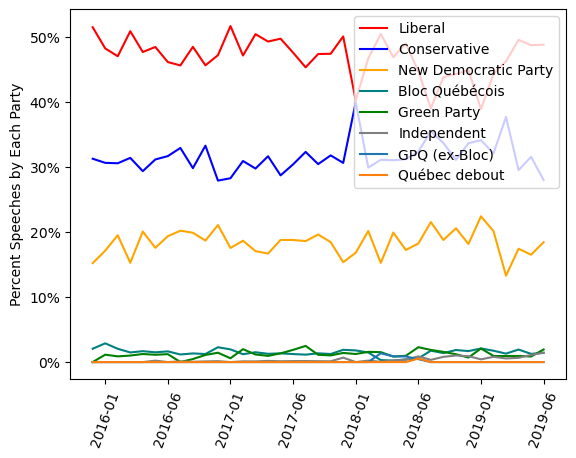

In [21]:
legend_list_of_parties = []
for party in party_speeches_by_month_dict.keys():
    colour = colour_dict[party] if party in colour_dict.keys() else None
    legend_list_of_parties += [party]
    plt.plot(party_speeches_by_month_dict[party]/np.sum(list(party_speeches_by_month_dict.values()), axis=0), color=colour)

tick_locations = np.arange(1, len(months_in_session), 5)
plt.ylabel("Percent Speeches by Each Party")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(ticks=tick_locations, labels=months_in_session[tick_locations], rotation=70)
plt.legend(legend_list_of_parties)
plt.show()

<b><u>Figure 5: Relative Number of Speeches Given by Each Party Over Time</u></b>:
>The Liberal Party made approximatly 50% of speeches in most months, with the Conservatives and New Democratic Party making approximatly 30% and 20% of speeches in most months respectivly. The jump in Conservative-given speeches in January 2018 corresponds to a month with an unusually low number of speeches given - Parliament was in recess from December 13, 2017 until January 29, 2018.

In [22]:
unique_party_speeches_by_month_dict = {}
for party in total_num_speeches_by_party.keys():
    unique_party_speeches_by_month_dict[party] = []

for month in months_in_session:
    y, m = month.split('-')
    for party in total_num_speeches_by_party.keys():
        if party in unique_party_speakers_by_month[int(y)][int(m)].index:
            unique_party_speeches_by_month_dict[party] += [len(unique_party_speakers_by_month[int(y)][int(m)][party])]
        else:
            unique_party_speeches_by_month_dict[party] += [0]

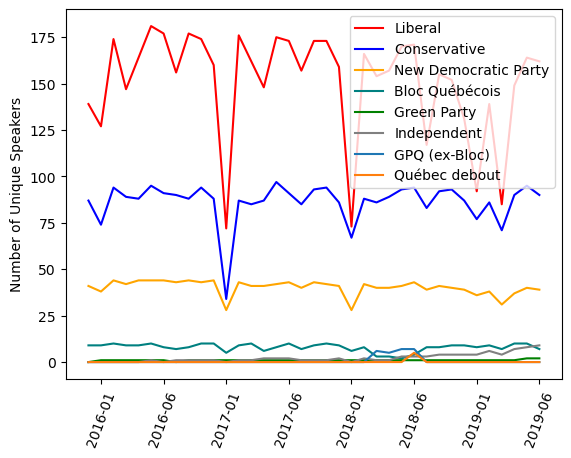

In [23]:
legend_list_of_parties = []
for party in unique_party_speeches_by_month_dict.keys():
    colour = colour_dict[party] if party in colour_dict.keys() else None
    legend_list_of_parties += [party]
    plt.plot(unique_party_speeches_by_month_dict[party], color=colour)

tick_locations = np.arange(1, len(months_in_session), 5)
plt.ylabel("Number of Unique Speakers")
plt.xticks(ticks=tick_locations, labels=months_in_session[tick_locations], rotation=70)
plt.legend(legend_list_of_parties)
plt.show()

<b><u>Figure 6: Number of Unqiue Speakers Given by Each Party Over Time</u></b>:
>In every month the Liberal party made the most overall speeches, followed closely by the Conservative party.

<b><u>Table 2: Top Ten Days by Number of Speeches Delivered and Main Topic Discussed</u></b>

In [24]:
top_10_days = nlargest(10, total_speeches_by_day, key = total_speeches_by_day.get)
num_speeches_10_days = [total_speeches_by_day[day] for day in top_10_days]

indices_10_days = np.concatenate([np.where(file_list==pd.to_datetime(day)) for day in top_10_days]).ravel()
topics_10_days = []

for day in indices_10_days:
    df_day = df_lst[day]
    topics_10_days += [df_day["subsubtopic"].value_counts().index[0]]

pd.DataFrame({"Date": top_10_days, "Num Speeches": num_speeches_10_days, "Main Topic Discussed": topics_10_days})

/opt/conda/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,Date,Num Speeches,Main Topic Discussed
0,2016-06-14,701,Opposition Motion—Internal trade
1,2019-05-15,664,"Department of National Defence—Main Estimates, 2019-20"
2,2018-05-24,635,"Department of Citizenship and Immigration—Main Estimates, 2018-19"
3,2018-05-22,624,"Department of Finance—Main Estimates, 2018-19"
4,2019-06-18,622,Opposition Motion—The Environment
5,2016-09-19,621,Procedure and House Affairs
6,2017-05-29,600,"National Defence—Main Estimates, 2017-18"
7,2018-06-11,576,Opposition Motion—Iran
8,2016-05-30,564,Finance — Main Estimates 2016-17
9,2018-01-29,556,Finance


<b><u>Table 3: Top 5 Most Prolific Speakers By Party</u></b>:
>As seen above, the majority of speeches were delivered by the Liberal Party. As Geoff Regan (Liberal) was Speaker of the House at this time, he delivered by far the most speeches. Other notable speakers include Carol Hughes (NDP) who was Assistant Deputy Speaker, and Bruce Stanton (Conservative) who was Deputy Speaker. Future Conservative Party leader Pierre Poilievre also ranked highly, as did Justin Trudeau and Andrew Scheer (leader of the Conservative party during the 42nd Parliament).

In [25]:
speakers_by_party = []
for party in list_of_parties:
    top_party_speakers = pd.DataFrame({party: full_df[full_df["speakerparty"] == party]["speakername"].value_counts().head()})
    if len(top_party_speakers) > 0:
        speakers_by_party += [top_party_speakers]

speakers_by_party_df_list = []
for df in speakers_by_party:
    party = df.columns[0]
    df = df.reset_index()
    df.columns = [(party, "Speaker"), (party, "Num Speeches")]
    tuples = df.transpose().index
    new_columns = pd.MultiIndex.from_tuples(tuples, names=[' ', ' '])
    df.columns = new_columns
    speakers_by_party_df_list += [df]
    
speakers_by_party_df = pd.concat(speakers_by_party_df_list, axis=1).fillna("")
speakers_by_party_df

Liberal                   Conservative               \
           Speaker Num Speeches           Speaker Num Speeches   
0  Geoff Regan      7701         Bruce Stanton     2953          
1  Kevin Lamoureux  3942         Garnett Genuis    1460          
2  Justin Trudeau   3060         Pierre Poilievre  1165          
3  Anthony Rota     2982         Gérard Deltell    1116          
4  Bardish Chagger  1606         Andrew Scheer     852           

   New Democratic Party                      Bloc Québécois               \
                Speaker Num Speeches                Speaker Num Speeches   
0  Carol Hughes          3201         Gabriel Ste-Marie      317           
1  Pierre-Luc Dusseault  653          Monique Pauzé          224           
2  Sheila Malcolmson     648          Luc Thériault          223           
3  Jenny Kwan            646          Xavier Barsalou-Duval  188           
4  Alexandre Boulerice   630          Rhéal Fortin           158           

               Independent                 Green Party               
                   Speaker Num Speeches        Speaker Num Speeches  
0  Hunter Tootoo            154          Elizabeth May  1431.0       
1  Erin Weir                122          Paul Manly     39.0         
2  Darshan Singh Kang       53                                       
3  Maxime Bernier           30                                       
4  Celina Caesar-Chavannes  21

# Language Analysis

In [26]:
def clean_str(string):
    clean_str_1 =  re.sub(r'[^\w] ', ' ', string)
    clean_str_2 = re.sub(r'\n', '', clean_str_1)
    clean_str_3 = clean_str_2.replace('\\', '')
    clean_str_4 = re.sub(r'\.', ' ', clean_str_3)
    return clean_str_4

In [27]:
stop_words = set(stopwords.words('english'))
stop_words.add("government")
stop_words.add("party")
stop_words.add("speaker")
stop_words.add("canada")
stop_words.add("canadian")
stop_words.add("member")
stop_words.add("would")
stop_words.add("bill")
stop_words.add("mr")

## Need more memory for this - will do

In [ ]:
speeches_by_party = full_df[["speakerparty", "speechtext"]]
combined_speeches = {}
combined_speeches_top_words = []
st = nltk.stem.SnowballStemmer(language='english', ignore_stopwords=False)

for party in list_of_parties:
    party_speeches = speeches_by_party[speeches_by_party["speakerparty"] == party]["speechtext"]
    party_str = (' '.join(party_speeches)).lower()
    party_str_clean = clean_str(party_str)
    combined_speeches[party] = party_str_clean

for party in combined_speeches.keys():
    combined_speech = ' '.join([st.stem(word) for word in combined_speeches[party].split()])
    most_common = pd.Series(combined_speech.split()).value_counts()
    combined_speeches_top_words += [pd.DataFrame({
        party: most_common[~most_common.index.isin(set(stop_words))].head(10)
    })]

In [ ]:
words_by_party_df_list = []
for df in combined_speeches_top_words:
    party = df.columns[0]
    df = df.reset_index()
    df.columns = [(party, "Word"), (party, "Num Appearances")]
    tuples = df.transpose().index
    new_columns = pd.MultiIndex.from_tuples(tuples, names=[' ', ' '])
    df.columns = new_columns
    words_by_party_df_list += [df]
    
top_words_by_party_df = pd.concat(words_by_party_df_list, axis=1).fillna("")
top_words_by_party_df

## Vader Score Analysis

In [8]:
def evalSpeech(speech_df):
    sid = SentimentIntensityAnalyzer()
    score_df = pd.DataFrame(columns=["speechID", "speakerName", "party", "speechText", "compound_score", "full_scores"])

    for idx, speech in speech_df.iterrows():
        ss = sid.polarity_scores(speech["speechtext"])
        score_df.loc[idx] = [speech["basepk"], speech["speakername"], speech["speakerparty"], speech["speechtext"], ss["compound"], ss]

    return score_df

In [9]:
vader_speeches = evalSpeech(full_df).dropna()

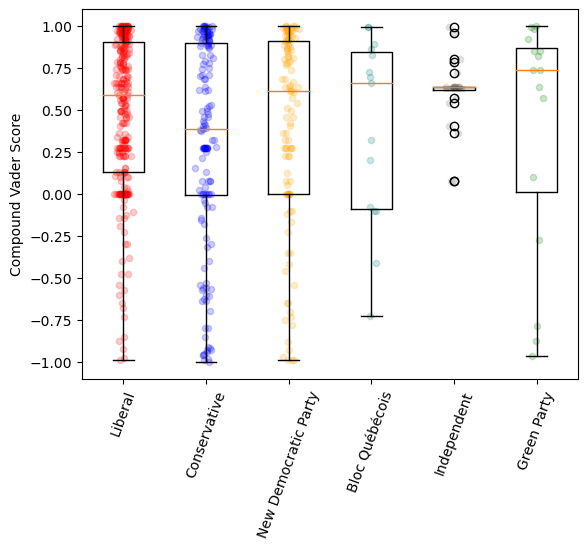

In [20]:
legend_list_of_parties = []
party_compound_vader = []
for party in list_of_parties:
    party_vader_scores = vader_speeches[vader_speeches["party"] == party]["compound_score"].rename(party)
    if len(party_vader_scores) > 0:
        party_compound_vader += [party_vader_scores]
        legend_list_of_parties += [party]
    
plt.boxplot(party_compound_vader)  

for i, d in enumerate(party_compound_vader):
    colour = colour_dict[d.name] if d.name in colour_dict.keys() else None
    x = np.random.normal(i + 1, 0.04, len(d))
    plt.scatter(x, d, alpha=0.2, s=20, color=colour)

plt.xticks(range(1, len(legend_list_of_parties) + 1), legend_list_of_parties, rotation=70)
plt.ylabel("Compound Vader Score")
plt.show()

<b><u>Figure 7: Average Compound Vader Scores of Speeches by Party</u></b>:
>The Liberal Party and New Democratic Party members are seen to make generally more positive speeches than the Conservatives. As this was a Liberal majority government, this makes sense - the Liberals are in power and the NDP hold similar views to them. The Conservative Party, being the official opposition party, held far more negative speeches.

# TF.IDF

In [12]:
aggregation_functions = {'speechtext': 'sum'}
df_party_agg = full_df.groupby(['speechdate', "speakerparty"]).aggregate(aggregation_functions).reset_index()

In [13]:
import scipy.sparse as sp

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [14]:
# Create documents per label
docs = pd.DataFrame({'Document': df_party_agg["speechtext"], 'Class': df_party_agg["speakerparty"]})
docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

# Create c-TF-IDF
count = CountVectorizer().fit_transform(docs_per_class.Document)
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs))

In [15]:
# Create bag of words
count_vectorizer = CountVectorizer().fit(docs_per_class.Document)
count = count_vectorizer.transform(docs_per_class.Document)
words = count_vectorizer.get_feature_names()

# Extract top 10 words per class
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()
words_per_class = {docs_per_class.iloc[label].Class: [words[index] for index in ctfidf[label].argsort()[-10:]]
    for label in docs_per_class.index}

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<b><u>Table 4: Top 10 Most Information-Giving Words by Party</u></b>:
>This table shows the ten most information giving words by party as found using tf.idf analysis

In [26]:
party_words = pd.DataFrame(words_per_class)
party_words

,Bloc Québécois,Conservative,GPQ (ex-Bloc),Green Party,Independent,Liberal,New Democratic Party,Québec debout
0,kpmg,recession,recipient,dilbit,regina,scarborough,ladysmith,excuses
1,shipyard,hike,irving,dafa,itk,enhanced,postal,ouvrière
2,banks,killing,inclusively,temperature,kivalliq,pan,medication,goon
3,secularism,butts,davie,falun,expulsion,modernize,spill,outremont
4,barbados,abiding,netflix,investor,uqaqti,ambitious,drummond,pot
5,davie,admiral,triage,diluent,inuktitut,counterparts,privatization,entirety
6,havens,terrorists,maritimes,bitumen,qujannamiik,strengthening,essex,formidable
7,quebeckers,tape,groupe,41st,ccf,brampton,hyacinthe,triage
8,bloc,gateway,parlementaire,saanich,nunavummiut,oakville,ceos,québec
9,québécois,norman,budworm,gulf,nunavut,lifted,nanaimo,debout
